# Univariate TVS Regression

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
# Change to the root directory
os.chdir("../")

# Import custom functions
from src.model.linearObjective import linearTauSolver
from src.model.linearTVSR import linearTVSRModel
import src.support as src

## Create Simulated data

For this example we define a simulated time series with linear form, y = A*x_i + C + e.

The arbitrary values of the the parameters are:
- A is the linear coefficient, and is set to 2
- C is a constant, set to 6.5
- e is random noise and is randomly drawn from N~(0,0.2)

In [3]:
# First we define effect size variable
A = np.array(2, dtype="float")
C = 6.5

We simulate a random series x(t), which represents the observed value of the input.

The series x(t) is assumed to have the following properties:
- x(t) should be stationary
- The effect, f(x(t)) must have a known value of zero. In other words, we know when the system input is 'off'
- Discrete time input with a finite number of impulses. An impulse is defined to be where f(x(t) != 0. 


In [4]:
# Create the Input signal x(t)
np.random.seed(17)
x = src.create_input(100, 0.2, binary=False)

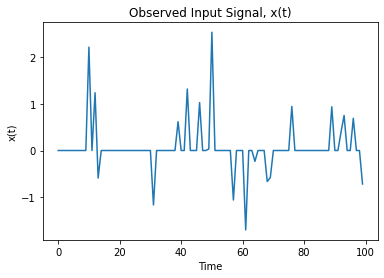

In [5]:
plt.plot(x)
plt.xlabel("Time")
plt.ylabel("x(t)")
plt.title("Observed Input Signal, x(t)")
plt.show()

However, due to some unknown process in our systen, there are random errors in the time domain for our variable x. In other words, after the input is provided to the system, there is a random time delay for each input impulse.

The true series (in terms of causing effects) is therefore x_i, where x_i = X(t + Tau). X(t + Tau) represents the decomposed matrix form of x(t), where each row represents a single impulse, shifted by some time delay (tau).

In [6]:
# Decompose the series x(t) into its matrix X(t)
X, bounds = src.decompose_vector(x, return_bounds=True)

The cell below shows the first three rows of the X(t) matrix, corresponding to the first 3 spikes in the diagram above.

In [7]:
print(np.round(X[:3,0:14],1))

[[ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   2.2  0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.2  0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  -0.6]]


Now we generate a random set of time delays (taus) and apply these to each row of the X(t) matrix. For the sake of example, the delays are drawn from a Normal distribution N~(0,2).

In [8]:
# Generate a random shift seq
np.random.seed(15)
real_shifts = np.round(np.random.randn(X.shape[0])*2)
real_shifts = np.array(real_shifts, dtype="int")

In [9]:
real_shifts

array([-1,  1,  0, -1,  0, -4, -2, -2, -1, -1,  0,  1,  1,  1, -1,  1,  0,
        3,  1,  0])

(array([1., 0., 2., 0., 5., 5., 0., 6., 0., 1.]),
 array([-4. , -3.3, -2.6, -1.9, -1.2, -0.5,  0.2,  0.9,  1.6,  2.3,  3. ]),
 <BarContainer object of 10 artists>)

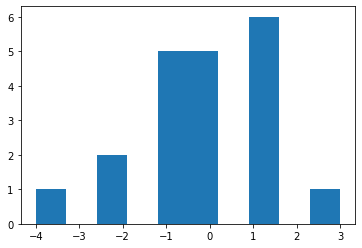

In [74]:
plt.hist(real_shifts)

Now we apply the shifts to the X(t) matrix, to produce X(t + Tau)

In [11]:
# Shift the series
X_shift = src.shift_array(X, np.array(real_shifts, dtype="int"))
X_shift = src.hor_mul(X_shift, A)

And then we create the simulated output y = A*x_i + C + e

In [75]:
# Retrieve the observed series, only for reference.
xi = np.sum(src.shift_array(X, np.array(real_shifts, dtype="int")), axis=0)
y = np.sum(X_shift, axis=0) + np.random.randn(X_shift.shape[1])*0.2 + C

0.20165704223123193

### Plot the Simulated Series

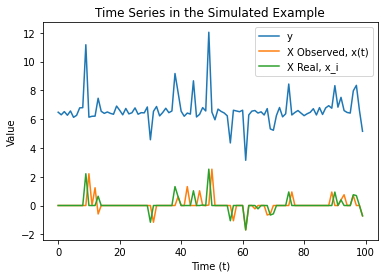

In [13]:
# Plot the sequences
plt.plot(y)
plt.plot(x)
plt.plot(xi)
plt.xlabel("Time (t)")
plt.ylabel("Value")
plt.title("Time Series in the Simulated Example")
plt.legend(["y","X Observed, x(t)","X Real, x_i"])
plt.show()

## Modelling

### Instantiate a model with default parameters

In [16]:
#TVS Regression - initialise a model
tvs = linearTVSRModel()

### Fit Model

Fit the model with the tvs regression class. The TVS Regression tries to find the maximum likelihood estimate of both the y-axis error (e) and the time delay errors (Tau). It does this via an inner optimisation of the Tau distribution and an outer optimisation of the regression parameters. Detailed information can be found in the paper.

Inner optimisation is taken care of by the custom tau optimiser module, written specifically for the purpose. In principle, the outer optimisation could be handled by a number of existing suitable methods. Due to the inner tau optimisation, the outer optimisation has a rough (bumpy) solution space. In addition, there can exist local maxima eg. for example where the value of the taus all = 0. For these reasons we have chosen differential evolution (from the scipy.optimize library). This seems to provide a good balance between exploration and greedy local searches. With some basic settings, fitting takes a few minutes. Comment the line "%%capture", if you would like to follow the progress.

In [19]:
%%capture
tvs.fit(x, y, method="differential_evolution", split=False)

### Results

In [27]:
# Print the summary
tvs.summary

     fun: -188.7999130336065
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 990
     nit: 20
 success: False
       x: array([1.9621318 , 1.5075449 , 0.26380802, 6.48932489])

Estimated Beta value: 1.96
<br>
Estimated Constant: 6.48
<br>
Estimated Tau SD: 1.51
<br>
Estimated Error: 0.26
<br>


#### For comparison the OLS regression results:

In [72]:
import statsmodels.api as sm

x1 = x[:,np.newaxis]
constant = np.repeat(1, x1.shape[0])
constant = constant[:,np.newaxis]
x1 = np.concatenate([x1, constant], axis=1)
x1 = pd.DataFrame(x1)
x1.columns = ["x","constant"]
x1.head()

mod = sm.OLS(y, x1)
res = mod.fit()
print(res.summary())
print("Residual Error SD: " + str(np.std(res.resid)))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     1.650
Date:                Thu, 21 Jan 2021   Prob (F-statistic):              0.202
Time:                        18:14:25   Log-Likelihood:                -144.56
No. Observations:                 100   AIC:                             293.1
Df Residuals:                      98   BIC:                             298.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x              0.2636      0.205      1.284      0.2

In [20]:
# Estimated best shift sequences (taus.)
tvs.shift_seq

array([-1,  1,  0, -1,  0, -4, -2,  0, -1, -1,  0,  1,  1,  1, -1,  1,  0,
        3,  1,  0])

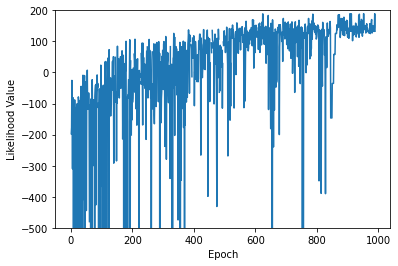

In [23]:
# Plot the fit history
tvs.history = tvs.history.reset_index()
plt.plot(tvs.history['likelihood'])
plt.ylim(-500,200)
plt.ylabel("Likelihood Value")
plt.xlabel("Epoch")
plt.show()

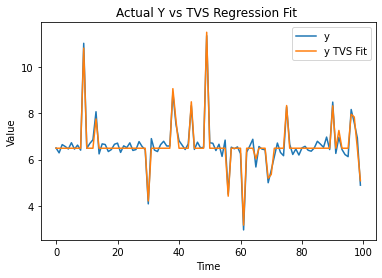

In [77]:
# Predict (fit)
f = linearTauSolver(X, y, tvs.summary.x[0], 0, tvs.summary.x[1], 0, tvs.summary.x[2], tvs.summary.x[3])

# Create a prediction
y_p = f.predict(tvs.shift_seq)

plt.plot(y)
plt.plot(y_p)
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend(["y","y TVS Fit"])
plt.title("Actual Y vs TVS Regression Fit ")
plt.show()

OLS Fit for Comparison

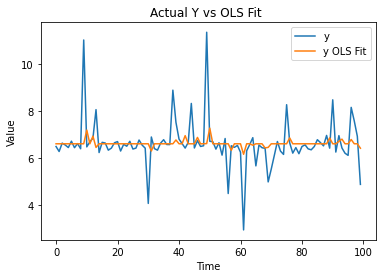

In [78]:
res = mod.fit()
y_ols = res.predict(x1)
plt.plot(y)
plt.plot(y_ols)
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend(["y","y OLS Fit"])
plt.title("Actual Y vs OLS Fit ")
plt.show()

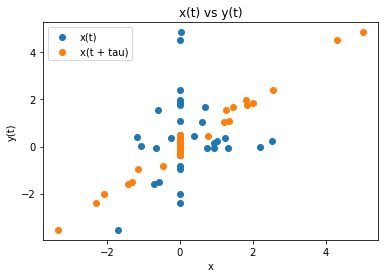

In [83]:
# Scatter Plots
plt.scatter(x, y - 6.5)
plt.scatter(y_p - 6.5, y - 6.5)
plt.xlabel("x")
plt.ylabel("y(t)")
plt.legend(["x(t)","x(t + tau)"])
plt.title("x(t) vs y(t)")
plt.show()
